In [ ]:
# If you encounter errors in the code, update the packages
# !pip install scipy==1.10.1
# !pip install numpy==1.21.2
# !pip install pandas==1.3.3

In [1]:
import pandas as pd
import numpy as np
from saver_func import SaveData

save = SaveData.save

# display options for numpy and pandas
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

## Instructions

You will have **30** total minutes to look through four tasks (10 for tasks 0 and 1, 10 for task 2, and 10 for task 3). Your goal is to understand the purpose of the code and also why the code's author made the choices they did as best as you can. If you run out of time on a given task, that’s okay and we will move onto the next task regardless.

You may write code and check documentation to better understand the code cells. Furthermore, we have implemented a function `save()` which takes two arguments, a DataFrame/Series and optionally a suffix for the file. An example using `Task 0` is seen here:

> ```python
> buoy_raw = pd.read_csv(fp, sep='\s+')
> save(buoy_raw, "raw")
> buoy = buoy_raw.dropna()
> ```

You are welcome to run the cells as many times as you need. Further, you may use the `save()` function as many times as you see fit. If you edit any lines, the original code is hidden in a markdown cell at the top of the notebook.

We will interrupt you after 10 minutes to prompt you to complete a [short survey](https://forms.gle/7jdxEDTrbd1EVRHT9) and move on to the next section. If you finish a section early, let us know before you move on.

## Scenario

You have joined a lab at the Scripps Institution of Oceanography. Your coworker, Alex, was tasked to make a quick analysis on a dataset and has since left for vacation. Your boss has asked you to get familiar with Alex's code in order to make additional analysis. Unfortunately for you, their code lacks comments or much neatness. Become familiar with Alex's code for future analysis. Subject matter is not necessary for the analysis tasks.

## Tasks

Broadly, the four tasks are as follows
- **Task 0**: Clean the dataset
- **Task 1**: Assess missingness
    - Definition: Data is considered "missing at random" if the chance that a value is missing depends on other columns, but not the actual missing value itself.
- **Task 2**: Imputation
- **Task 3**: Compare imputation to original

# Alex's Code

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [3]:
### TASK 0

# Link to txt file: https://raw.githubusercontent.com/ch-lum/table_information/main/buoy.txt
# Link to schema: https://www.ndbc.noaa.gov/obsdes.shtml

fp = "buoy.txt"
buoy_raw = pd.read_csv(fp, sep="\s+")
buoy = buoy_raw.dropna()
buoy = buoy.replace(r"-+$", np.nan, regex=True)
buoy = buoy[buoy["TIME"] != "TIME"]
buoy = buoy.dropna(axis=1, how="all").reset_index(drop=True)
non_numeric_cols = set(["D", "T1", "SwD", "WWD", "STEEPNESS"])
numeric_cols = list(set(buoy.columns) - non_numeric_cols)
buoy.loc[:, numeric_cols] = buoy.loc[:, numeric_cols].apply(
    pd.to_numeric, errors="coerce"
)

buoy

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_8985/1803450607.py:7: SyntaxWarning: invalid escape sequence '\s'
  buoy_raw = pd.read_csv(fp, sep="\s+")


,D,T1,TIME,LAT,...,WWH,WWP,WWD,STEEPNESS
0,46275,B,2100,33.29,...,1.97,5.6,W,SWELL
1,46086,B,2100,32.5,...,NaN,NaN,NaN,NaN
2,SHIP,S,2100,33.6,...,NaN,NaN,NaN,NaN
3,46025,B,2110,33.76,...,NaN,NaN,NaN,NaN
4,46025,B,2100,33.76,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2491,MBXC1,O,910,35.37,...,NaN,NaN,NaN,NaN
2492,MBXC1,O,900,35.37,...,NaN,NaN,NaN,NaN
2493,46259,B,956,34.77,...,8.2,7.7,NW,AVERAGE
2494,46259,B,926,34.77,...,8.86,9.9,NW,AVERAGE


variable
APD     True
ATMP    True
DEWP    True
DPD     True
GST     True
        ... 
WTMP    True
WVHT    True
WWD     True
WWH     True
WWP     True
Length: 24, dtype: bool

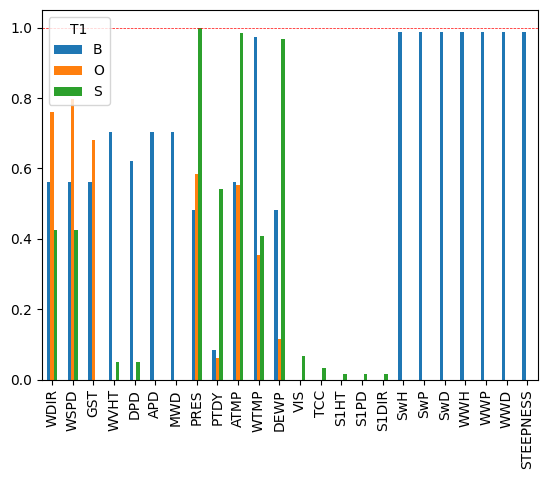

In [4]:
### TASK 1

totals = buoy["T1"].value_counts()
missing_some = buoy.drop(buoy.columns[~buoy.isnull().any()].drop("T1"), axis=1)
present_counts = missing_some.groupby("T1").count()
cont_tables = present_counts.melt(ignore_index=False).rename(
    columns={"value": "Present"}
)
cont_tables["Missing"] = cont_tables.groupby("variable")["Present"].transform(
    lambda x: totals - x
)
missingness = cont_tables.groupby("variable").apply(
    lambda x: stats.chi2_contingency(x).pvalue < 0.0001
)
present_props = present_counts.div(totals, axis=0)
present_props.T.plot(kind="bar").axhline(
    y=1.0, color="red", linestyle="--", linewidth=0.5
)

missingness

In [5]:
### TASK 2

no_ships = buoy.groupby("T1").filter(lambda x: len(x) > 200)
melted = no_ships.melt(id_vars="T1", ignore_index=False)
melted = melted.groupby("variable").filter(
    lambda x: x.groupby("T1")["value"].count().min() > 200
)
un_melted = melted.reset_index().pivot(
    index="index", columns="variable", values="value"
)
no_ships = pd.concat([no_ships["T1"], un_melted], axis=1).reset_index(drop=True)
quantiles = pd.qcut(no_ships["TIME"], 25)
missing_cols = no_ships.isnull().any()
means = no_ships.groupby([quantiles, "T1"])[no_ships.columns[missing_cols]].mean()
imputation = (
    pd.merge(
        no_ships.set_index([quantiles, "T1"]).loc[:, "D"],
        means,
        left_index=True,
        right_index=True,
    )
    .loc[:, missing_cols]
    .reset_index()
)
imputed = no_ships.copy()
imputed.loc[:, missing_cols] = no_ships.loc[:, missing_cols].combine_first(
    imputation.loc[:, missing_cols]
)

imputed

/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_8985/4266247330.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = no_ships.groupby([quantiles, "T1"])[no_ships.columns[missing_cols]].mean()


,T1,ATMP,D,DIST,...,TIME,WDIR,WSPD,WTMP
0,B,60.3,46275,28,...,2100,300.0,10.73,63.3
1,B,57.9,46086,46,...,2100,280.0,9.7,61.0
2,B,57.9,46025,104,...,2110,290.0,7.8,61.9
3,B,57.7,46025,104,...,2100,280.0,7.8,61.9
4,B,56.8,46047,118,...,2110,310.0,17.5,58.8
...,...,...,...,...,...,...,...,...,...
2432,O,56.42,MBXC1,233,...,920,213.17,2.55,58.3
2433,O,56.42,MBXC1,233,...,910,213.17,2.55,58.1
2434,O,56.42,MBXC1,233,...,900,213.17,2.55,57.9
2435,B,55.55,46259,240,...,956,290.95,13.31,55.8


/var/folders/0y/gbwmzjp93k12t06yhk8_2p7h0000gn/T/ipykernel_8985/1148100389.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  d_h = together.pivot_table(


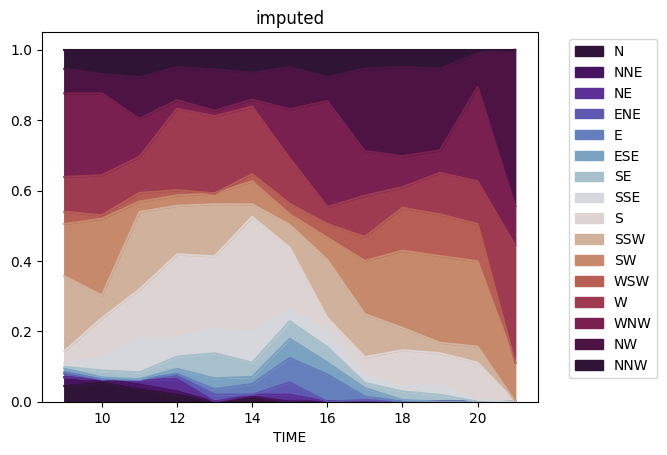

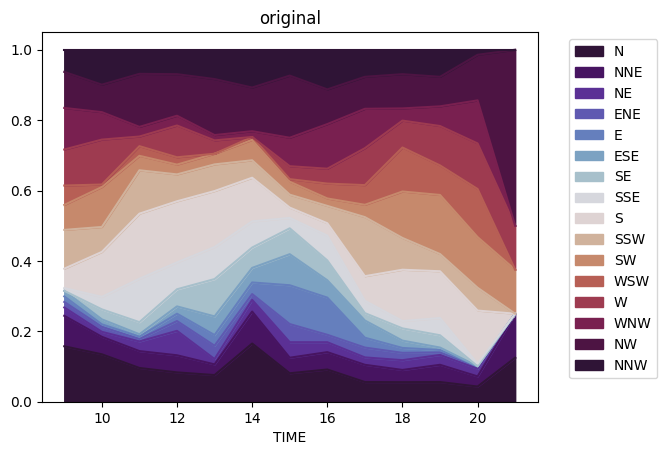

In [6]:
### TASK 3

together = pd.concat([imputed, no_ships], keys=["imputed", "original"])
together = together[(together["TIME"] >= 900) & (together["TIME"] <= 2100)]
together = together[["TIME", "WDIR"]]
together.loc[:, "WDIR_adj"] = (together["WDIR"] + (360 / 16 / 2)) % 360
together = together.reset_index()
directions = pd.cut(
    together["WDIR_adj"], bins=np.linspace(0, 360, 17), include_lowest=True
)
hours = together["TIME"] // 100
d_h = together.pivot_table(
    index=["level_0", hours],
    columns=directions,
    values="TIME",
    aggfunc="count",
)
d_h.columns = [
    "N",
    "NNE",
    "NE",
    "ENE",
    "E",
    "ESE",
    "SE",
    "SSE",
    "S",
    "SSW",
    "SW",
    "WSW",
    "W",
    "WNW",
    "NW",
    "NNW",
]
d_h = d_h.fillna(0)
d_h_props = d_h.div(d_h.sum(axis=1), axis=0)

for key in d_h.index.levels[0]:
    axes = d_h_props.xs(key).plot(kind="area", colormap="twilight_shifted")
    axes.set_title(key)
    axes.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

In [7]:
directions

0       (292.5, 315.0]
1       (270.0, 292.5]
2       (270.0, 292.5]
3       (315.0, 337.5]
4       (270.0, 292.5]
             ...      
4859               NaN
4860               NaN
4861               NaN
4862               NaN
4863               NaN
Name: WDIR_adj, Length: 4864, dtype: category
Categories (16, interval[float64, right]): [(-0.001, 22.5] < (22.5, 45.0] < (45.0, 67.5] < (67.5, 90.0] ... (270.0, 292.5] < (292.5, 315.0] < (315.0, 337.5] < (337.5, 360.0]]

## Code (in markdown)

```python
import pandas as pd
import numpy as np
import scipy.stats as stats

################################################################

### TASK 0

# Link to txt file: https://raw.githubusercontent.com/ch-lum/table_information/main/buoy.txt
# Link to schema: https://www.ndbc.noaa.gov/obsdes.shtml

fp = 'buoy.txt'
buoy_raw = pd.read_csv(fp, sep='\s+')
buoy = buoy_raw.dropna()
buoy = buoy.replace(r"-+$", np.nan, regex=True)
buoy = buoy[buoy["TIME"] != "TIME"]
buoy = buoy.dropna(axis=1, how='all').reset_index(drop=True)
buoy.iloc[:, 2:-5] = buoy.iloc[:, 2:-5].apply(pd.to_numeric, errors='coerce')
buoy.iloc[:, -4:-2] = buoy.iloc[:, -4:-2].apply(pd.to_numeric, errors='coerce')

buoy

################################################################

### TASK 1

totals = buoy["T1"].value_counts()
missing_some = buoy.drop(buoy.columns[~buoy.isnull().any()].drop("T1"), axis=1)
present_counts = missing_some.groupby("T1").count()
cont_tables = present_counts.melt(ignore_index=False).rename(
    columns={"value": "Present"}
)
cont_tables["Missing"] = cont_tables.groupby("variable")["Present"].transform(
    lambda x: totals - x
)
missingness = cont_tables.groupby("variable").apply(
    lambda x: stats.chi2_contingency(x).pvalue< 0.0001
)
present_props = present_counts.div(totals, axis=0)
present_props.T.plot(kind="bar").axhline(
    y=1.0, color="red", linestyle="--", linewidth=0.5
)

missingness

################################################################

### TASK 2

no_ships = buoy.groupby("T1").filter(lambda x: len(x) > 200)
melted = no_ships.melt(id_vars="T1", ignore_index=False)
melted = melted.groupby("variable").filter(
    lambda x: x.groupby("T1")["value"].count().min() > 200
)
un_melted = melted.reset_index().pivot(
    index="index", columns="variable", values="value"
)
no_ships = pd.concat([no_ships["T1"], un_melted], axis=1).reset_index(drop=True)
quantiles = pd.qcut(no_ships["TIME"], 25)
missing_cols = no_ships.isnull().any()
means = no_ships.groupby([quantiles, "T1"])[
    no_ships.columns[missing_cols]
].mean()
imputation = (
    pd.merge(
        no_ships.set_index([quantiles, "T1"]).loc[:, "D"],
        means,
        left_index=True,
        right_index=True,
    )
    .loc[:, missing_cols]
    .reset_index()
)
imputed = no_ships.copy()
imputed.loc[:, missing_cols] = no_ships.loc[:, missing_cols].combine_first(
    imputation.loc[:, missing_cols]
)

imputed

################################################################

### TASK 3

together = pd.concat([imputed, no_ships], keys=["imputed", "original"])
together = together[(together["TIME"] >= 900) & (together["TIME"] <= 2100)]
together = together[["TIME", "WDIR"]]
together.loc[:, "WDIR_adj"] = (together["WDIR"] + (360 / 16 / 2)) % 360
together = together.reset_index()
directions = pd.cut(
    together["WDIR_adj"], bins=np.linspace(0, 360, 17), include_lowest=True
)
hours = together["TIME"] // 100
d_h = together.pivot_table(
    index=["level_0", hours],
    columns=directions,
    values="TIME",
    aggfunc="count",
)
d_h.columns = [
    "N",
    "NNE",
    "NE",
    "ENE",
    "E",
    "ESE",
    "SE",
    "SSE",
    "S",
    "SSW",
    "SW",
    "WSW",
    "W",
    "WNW",
    "NW",
    "NNW",
]
d_h = d_h.fillna(0)
d_h_props = d_h.div(d_h.sum(axis=1), axis=0)

for key in d_h.index.levels[0]:
    axes = d_h_props.xs(key).plot(kind="area", colormap="twilight_shifted")
    axes.set_title(key)
    axes.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
```